## 動畫

### 先照之前的，讀取資料

In [1]:
import tqdm
import tarfile
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from urllib.request import urlopen
from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

# 檔案名稱格式
filename_format="M06A_{year:04d}{month:02d}{day:02d}.tar.gz".format
xz_filename_format="xz/M06A_{year:04d}{month:02d}{day:02d}.tar.xz".format
csv_format = "M06A/{year:04d}{month:02d}{day:02d}/{hour:02d}/TDCS_M06A_{year:04d}{month:02d}{day:02d}_{hour:02d}0000.csv".format

In [2]:
# 打開剛才下載的檔案試試
data_config ={"year":2016, "month":12, "day":18}
tar = tarfile.open(filename_format(**data_config), 'r')

In [3]:
# 如果沒有下載，可以試試看 xz 檔案
#data_dconfig ={"year":2016, "month":11, "day":18}
#tar = tarfile.open(xz_filename_format(**data_config), 'r')

In [4]:
# 設定欄位名稱
M06A_fields = ['VehicleType',
               'DetectionTime_O','GantryID_O',
               'DetectionTime_D','GantryID_D ',
               'TripLength', 'TripEnd', 'TripInformation']
# 打開裡面 10 點鐘的資料
csv = tar.extractfile(csv_format(hour=10, **data_config))
# 讀進資料
data = pandas.read_csv(csv, names=M06A_fields)
# 檢查異常的資料
print("異常資料數:", data[data.TripEnd == 'N'].shape[0])
# 去除異常資料
data = data[data.TripEnd == 'Y']
# 只保留 TripInformation 和 VehicleType
data = data[['VehicleType', "TripInformation"]]
# 看前五筆
data.head(5)

異常資料數: 0


VehicleType                                    TripInformation
0           31  2016-12-18 10:00:50+01F1045N; 2016-12-18 10:04...
1           31  2016-12-18 10:34:24+01F3525S; 2016-12-18 10:37...
2           31  2016-12-18 10:57:33+03F3854N; 2016-12-18 11:12...
3           31  2016-12-18 10:05:11+03F0525S; 2016-12-18 10:07...
4           31  2016-12-18 10:35:46+01F3185S; 2016-12-18 10:38...

In [5]:
import datetime
# 用來解析時間格式
def strptime(x):
    return datetime.datetime(int(x[:4]), int(x[5:7]), int(x[8:10]), 
                             int(x[11:13]), int(x[14:16]), int(x[17:19]) )

def parse_tripinfo(tripinfo):
    split1 = tripinfo.split("; ")
    return [(strptime(t), t[20:]) for t in split1]
data.head(10).TripInformation.apply(parse_tripinfo)

# progress bar
tqdm.tqdm.pandas()

# 新增一欄
data['Trip'] = data.TripInformation.progress_apply(parse_tripinfo)

100%|██████████| 211247/211247 [00:02<00:00, 88189.34it/s] 


In [6]:
node_data = pandas.read_json("node_data.json")
node_data.head(10)

Unnamed: 6 Unnamed: 8         交流道(起)         交流道(迄)  小車牌價  收費區\n設定里程  \
01F0005N          N          E       基隆(長庚醫院)       基隆端(基隆港)   1.3        1.1   
01F0005S          N          E       基隆端(基隆港)       基隆(長庚醫院)   1.3        1.1   
01F0017N          N          E             八堵       基隆(長庚醫院)   1.4        1.2   
01F0017S          N          E       基隆(長庚醫院)             八堵   1.4        1.2   
01F0029N          N          E    大華系統(連接台62)             八堵   3.3        2.8   
01F0029S          N          E             八堵    大華系統(連接台62)   3.3        2.8   
01F0061N          N          E             五堵    大華系統(連接台62)   2.1        1.8   
01F0061S          N          E    大華系統(連接台62)             五堵   2.1        1.8   
01F0099N          N          E  汐止&汐止系統(連接國3)             五堵   4.4        3.7   
01F0099S          N          E             五堵  汐止&汐止系統(連接國3)   4.4        3.7   

         方向      經度(東經)        編號     緯度(北緯)   速限  
01F0005N  N  121.731636  01F0005N  25.118311  100  
01F0005S  S  121.731764  01F0005S  25.118786  100  
01F0017N  N  121.725906  01F0017N  25.109567  100  
01F0017S  S  121.725906  01F0017S  25.109567  100  
01F0029N  N  121.717369  01F0029N  25.103111  100  
01F0029S  S  121.717369  01F0029S  25.103111  100  
01F0061N  N  121.693483  01F0061N  25.088394  100  
01F0061S  S  121.693483  01F0061S  25.088394  100  
01F0099N  N  121.659422  01F0099N  25.076044  100  
01F0099S  S  121.659478  01F0099S  25.076264  100

In [7]:
position_dict=node_data.apply(lambda t: [t["經度(東經)"], t["緯度(北緯)"]], axis=1).to_dict()

In [8]:
start_time = datetime.datetime(data_config['year'],data_config['month'],data_config['day'])

## 先用一筆資料試試看

In [9]:
t = [(a[0]-start_time).total_seconds()/60/60 for a in data.Trip[0]]
position = np.array([position_dict[a[1]] for a in data.Trip[0]])

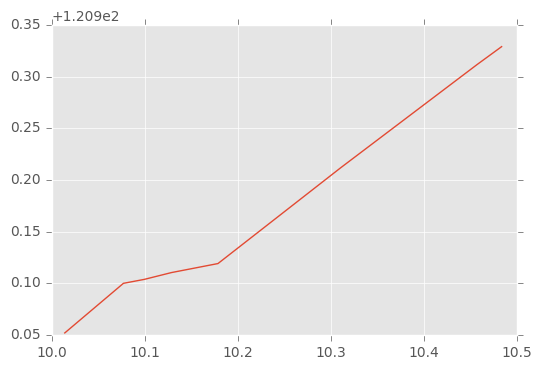

In [10]:
# 時間 - X 座標
plt.plot(t,position[:,0])

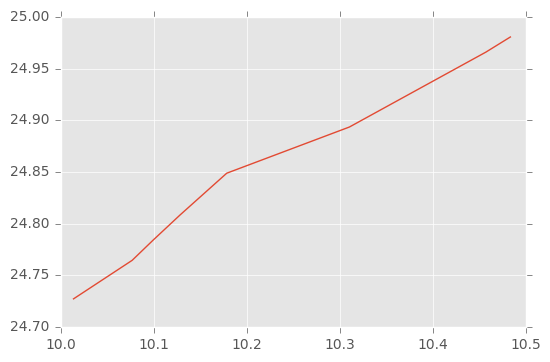

In [11]:
# 時間 - Y 座標
plt.plot(t,position[:,1])

### 在圖上畫軌跡

In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# 網路上的台灣地圖，有經緯度
taiwan_img_url="http://gallery.mjes.ntpc.edu.tw/gallery2/main.php?g2_view=core.DownloadItem&g2_itemId=408&g2_serialNumber=1"
taiwan_img = Image.open(urlopen(taiwan_img_url))
#taiwan_img = Image.open("taiwan.png")

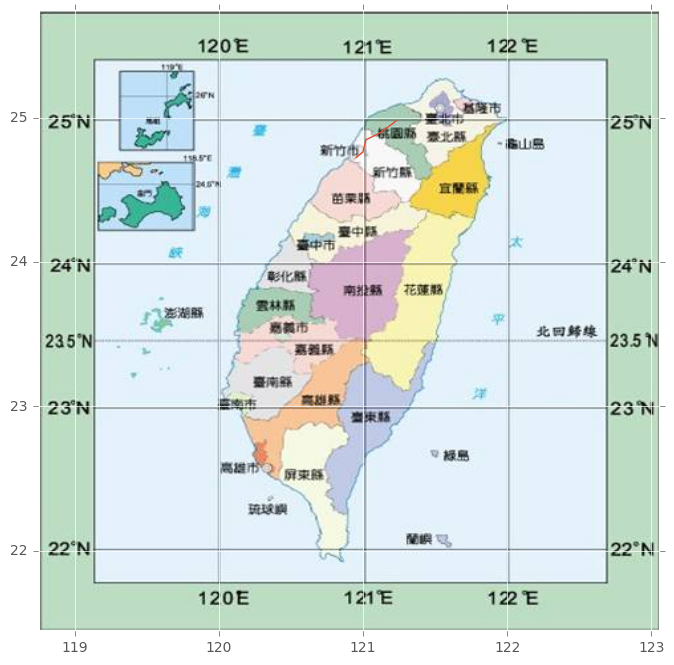

In [13]:
fig = plt.gcf()
fig.set_size_inches(8,8)
extent=[118.75,123.05,21.45,25.75]
plt.xlim(*extent[:2])
plt.ylim(*extent[2:])
plt.plot(position[:,0], position[:,1])
plt.imshow(np.array(taiwan_img), extent=extent);

### 用 scipy 差值

In [14]:
from scipy.interpolate import interp1d

In [15]:
t_space = np.arange(int(min(t)*60+1)/60,max(t),1/60)

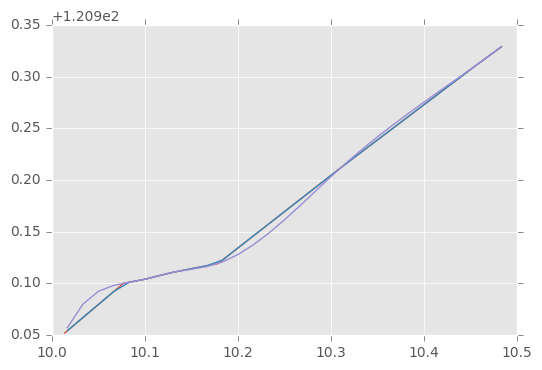

In [16]:
f1 = interp1d(t, position, 'linear', axis=0)
f3 = interp1d(t, position, 'cubic', axis=0)
plt.plot(t,position[:,0])
plt.plot(t_space, f1(t_space)[:,0])
plt.plot(t_space, f3(t_space)[:,0]);

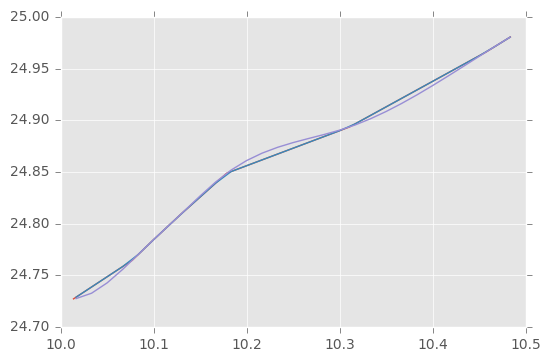

In [17]:
plt.plot(t,position[:,1])
plt.plot(t_space, f1(t_space)[:,1])
plt.plot(t_space, f3(t_space)[:,1]);

### 畫個動畫看看

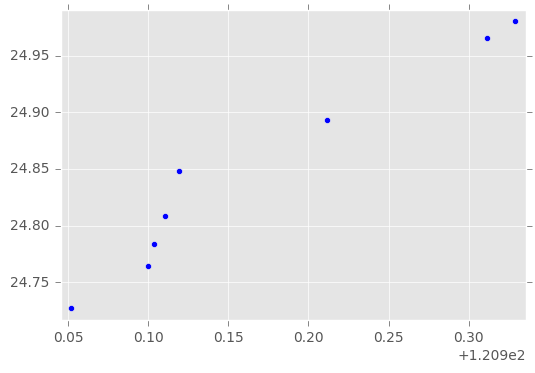

In [18]:
# 打底
scatters = plt.scatter(position[:,0], position[:,1])
plt.margins(0,0)
fig = plt.gcf()

In [19]:
# 開始動畫
from matplotlib import animation, rc
rc('animation', html='html5')
curv = f1(t_space)
def animate(tick):
    scatters.set_offsets([curv[tick]])
    return [scatters]
anim = animation.FuncAnimation(fig, animate, 
                               frames=len(t_space), interval=100, blit=True)

anim

## 畫在地圖上看看

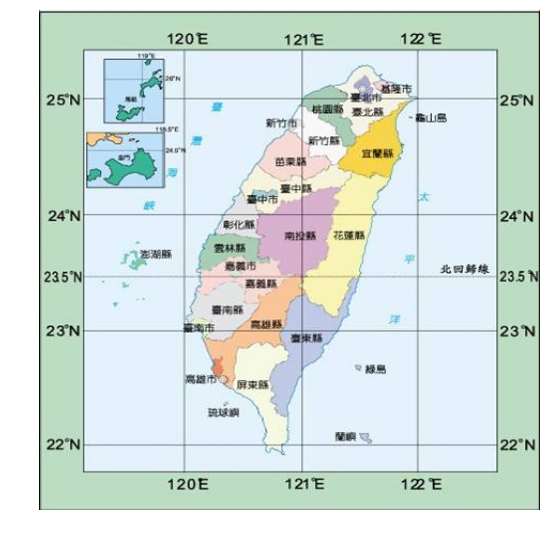

In [20]:
# 打底
fig = plt.gcf()
fig.set_size_inches(5,5)
extent=[118.75,123.05,21.45,25.75]
plt.xlim(*extent[:2])
plt.ylim(*extent[2:])
fig = plt.gcf()
scatters = plt.scatter([],[], alpha=0.5, color='red')
desc_text = plt.text(119,25.3,"",size=25, color="#ff00ff")
plt.axis('off')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
bg = plt.imshow(np.array(taiwan_img), extent=extent)

In [21]:
# 動畫
curv = f1(t_space)
def animate(tick):
    scatters.set_offsets([curv[tick]])
    return [scatters]
anim = animation.FuncAnimation(fig, animate, 
                               frames=29, interval=100, blit=True)

anim

In [22]:
from random import randint
scatter_data = [[] for i in range(24*60)]
scatter_color = [[] for i in range(24*60)]

for trip in tqdm.tqdm(data.Trip.sample(3000)):
    t = [(a[0]-start_time).total_seconds()/60 for a in trip]
    position = np.array([position_dict[a[1]] for a in trip])
    color="#{:02x}{:02x}{:02x}".format(randint(0,255),randint(0,255),randint(0,255))
    if len(t)<2:
        continue
    kind = "slinear"
    inter_f = interp1d(t, position, kind, axis=0)
    t_space = np.arange(int(min(t)+1),int(max(t))+1)
    curve = inter_f(t_space)
    for j,p in enumerate(t_space):
        scatter_data[p%(24*60)].append(curve[j])
        scatter_color[p%(24*60)].append(color)
for i in range(24*60):
    scatter_data[i]=np.array(scatter_data[i])

100%|██████████| 3000/3000 [00:00<00:00, 9476.30it/s]


In [23]:
# 先畫出 10:00-12:00
with tqdm.tqdm(total=2*60) as pbar:
    def animate(tick):
        pbar.update(1)
        scatters.set_color(scatter_color[tick+600])
        scatters.set_offsets(scatter_data[tick+600])
        scatters.set_alpha(0.3)
        scatters.set
        hh=int((tick+600)/60)
        mm = tick%60
        desc_text.set_text("{:02d}:{:02d}".format(hh,mm))
        return [scatters, desc_text]
    anim = animation.FuncAnimation(fig, animate, 
                                   frames=2*60, interval=100, blit=True)

    display(anim)

100%|██████████| 120/120 [00:02<00:00, 49.42it/s]

122it [00:02, 41.29it/s]                         


In [24]:
csvs = (tar.extractfile(csv_format(hour=hr, **data_config)) for hr in tqdm.trange(24))

data = pandas.concat([pandas.read_csv(csv, names=M06A_fields) for csv in csvs])
print("資料大小", data.shape)

# 檢查異常的資料
print("異常資料數:", data[data.TripEnd == 'N'].shape[0])

# 去除異常資料
data = data[data.TripEnd == 'Y']

# 把焦點放在 TripInformation 和 VehicleType
data = data[['VehicleType', "TripInformation"]]
data['Trip'] = data.TripInformation.progress_apply(parse_tripinfo)

100%|██████████| 24/24 [00:31<00:00,  1.37s/it]


資料大小 (3350606, 8)
異常資料數: 0


100%|██████████| 3350606/3350606 [00:38<00:00, 86653.66it/s]


In [25]:
from random import randint
scatter_data = [[] for i in range(24*60)]
scatter_color = [[] for i in range(24*60)]

for trip in tqdm.tqdm(data.Trip.sample(3000*24)):
    t = [(a[0]-start_time).total_seconds()/60 for a in trip]
    position = np.array([position_dict[a[1]] for a in trip])
    color="#{:02x}{:02x}{:02x}".format(randint(0,255),randint(0,255),randint(0,255))
    if len(t)<2:
        continue
    kind = "linear"
    inter_f = interp1d(t, position, kind, axis=0)
    t_space = np.arange(int(min(t)+1),int(max(t))+1)
    curve = inter_f(t_space)
    for j,p in enumerate(t_space):
        scatter_data[p%(24*60)].append(curve[j])
        scatter_color[p%(24*60)].append(color)
for i in range(24*60):
    scatter_data[i]=np.array(scatter_data[i])

100%|██████████| 72000/72000 [00:06<00:00, 11695.39it/s]


In [26]:
# 先畫出 0:00-23:59
def animate(tick):
    pbar.update(1)
    scatters.set_color(scatter_color[tick])
    scatters.set_offsets(scatter_data[tick])
    scatters.set_alpha(0.3)
    scatters.set
    hh=int(tick/60)
    mm = tick%60
    desc_text.set_text("{:02d}:{:02d}".format(hh,mm))
    return [scatters, desc_text]
with tqdm.tqdm(total=24*60) as pbar:
    display(animation.FuncAnimation(fig, animate, frames=24*60, interval=100, blit=True))

100%|█████████▉| 1439/1440 [00:53<00:00, 41.42it/s]

1442it [00:53, 27.01it/s]                          


## Q 
可以試著用下面程式碼存成檔案
```python
with tqdm.tqdm(total=24*60) as pbar:
    anim = animation.FuncAnimation(fig, animate, frames=24*60, interval=100, blit=True)
    anim.save("traffic.mp4", codec="h264")
```

## 即時畫出動畫

In [ ]:
from ipywidgets import Image
import time
from io import BytesIO
anim = animation.FuncAnimation(fig, animate, frames=24*60, interval=100, blit=True)
img=Image(width=400)
display(img)
target_time = time.time() + anim._interval/1000
for d in anim.new_saved_frame_seq():    
    anim._draw_next_frame(d, blit=False)
    with BytesIO() as bio:
        fig.savefig(bio, format="png")
        img.value = bio.getvalue()
    now = time.time()
    if target_time > now:
        time.sleep(target_time-now)
    target_time += anim._interval/1000